In [6]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications import DenseNet121


In [15]:
# prompt: extract the zip file as folders

import zipfile

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/CDataset.zip', 'r')
zip_ref.extractall('/content/drive/MyDrive/CDataset')
zip_ref.close()


In [16]:
# Verify the directory structure
for dirname, _, filenames in os.walk('/content/drive/My Drive/CDataset'):
    print(dirname)
    for filename in filenames:
        print(os.path.join(dirname, filename))


Streaming output truncated to the last 5000 lines.
/content/drive/My Drive/CDataset/train/PNEUMONIA/person1180_virus_2007.jpeg
/content/drive/My Drive/CDataset/train/PNEUMONIA/person1180_virus_2008.jpeg
/content/drive/My Drive/CDataset/train/PNEUMONIA/person1180_virus_2009.jpeg
/content/drive/My Drive/CDataset/train/PNEUMONIA/person1180_virus_2010.jpeg
/content/drive/My Drive/CDataset/train/PNEUMONIA/person1180_virus_2011.jpeg
/content/drive/My Drive/CDataset/train/PNEUMONIA/person1180_virus_2012.jpeg
/content/drive/My Drive/CDataset/train/PNEUMONIA/person1180_virus_2013.jpeg
/content/drive/My Drive/CDataset/train/PNEUMONIA/person1180_virus_2014.jpeg
/content/drive/My Drive/CDataset/train/PNEUMONIA/person1180_virus_2015.jpeg
/content/drive/My Drive/CDataset/train/PNEUMONIA/person1181_bacteria_3129.jpeg
/content/drive/My Drive/CDataset/train/PNEUMONIA/person1181_virus_2016.jpeg
/content/drive/My Drive/CDataset/train/PNEUMONIA/person1182_virus_2017.jpeg
/content/drive/My Drive/CDataset/t

In [17]:
# Set the data directory paths
data_dir = '/content/drive/My Drive/CDataset'
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')


In [18]:
target_size = (224, 224)
num_classes = 4  # Assuming four classes: COVID-19, NORMAL, PNEUMONIA, TB

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=target_size,
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=32,
    class_mode='categorical'
)


Found 6326 images belonging to 4 classes.
Found 38 images belonging to 4 classes.
Found 771 images belonging to 4 classes.


In [19]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreeze some layers for fine-tuning
for layer in base_model.layers[-30:]:
    layer.trainable = True

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])


29084464/29084464 [==============================] - 2s 0us/step


In [20]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [21]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [22]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=30,  # Increase the number of epochs
    callbacks=[reduce_lr, early_stopping]
)


Epoch 1/30
197/197 [==============================] - 322s 1s/step - loss: 0.5272 - accuracy: 0.8119 - val_loss: 0.9993 - val_accuracy: 0.6875 - lr: 1.0000e-04
Epoch 2/30
197/197 [==============================] - 194s 985ms/step - loss: 0.1982 - accuracy: 0.9299 - val_loss: 0.2146 - val_accuracy: 0.9062 - lr: 1.0000e-04
Epoch 3/30
197/197 [==============================] - 206s 1s/step - loss: 0.1473 - accuracy: 0.9465 - val_loss: 0.2493 - val_accuracy: 0.9062 - lr: 1.0000e-04
Epoch 4/30
197/197 [==============================] - 223s 1s/step - loss: 0.1183 - accuracy: 0.9585 - val_loss: 0.0666 - val_accuracy: 0.9375 - lr: 1.0000e-04
Epoch 5/30
197/197 [==============================] - 191s 971ms/step - loss: 0.1002 - accuracy: 0.9644 - val_loss: 0.4169 - val_accuracy: 0.9375 - lr: 1.0000e-04
Epoch 6/30
197/197 [==============================] - 188s 954ms/step - loss: 0.0926 - accuracy: 0.9697 - val_loss: 0.1469 - val_accuracy: 0.9062 - lr: 1.0000e-04
Epoch 7/30
197/197 [===========

In [23]:
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f'Overall Test Accuracy: {test_acc * 100:.2f}%')


24/24 [==============================] - 11s 451ms/step - loss: 0.2100 - accuracy: 0.9453
Overall Test Accuracy: 94.53%


In [25]:
# Print final training and validation accuracy
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
print(f'Final Training Accuracy: {final_train_acc * 100:.2f}%')
print(f'Final Validation Accuracy: {final_val_acc * 100:.2f}%')

Final Training Accuracy: 99.27%
Final Validation Accuracy: 96.88%


In [26]:
# Print the train loss and val and test loss
print(f'Train Loss: {history.history["loss"][-1]}')
print(f'Validation Loss: {history.history["val_loss"][-1]}')
print(f'Test Loss: {test_loss}')


Train Loss: 0.023495767265558243
Validation Loss: 0.1388605684041977
Test Loss: 0.20996339619159698


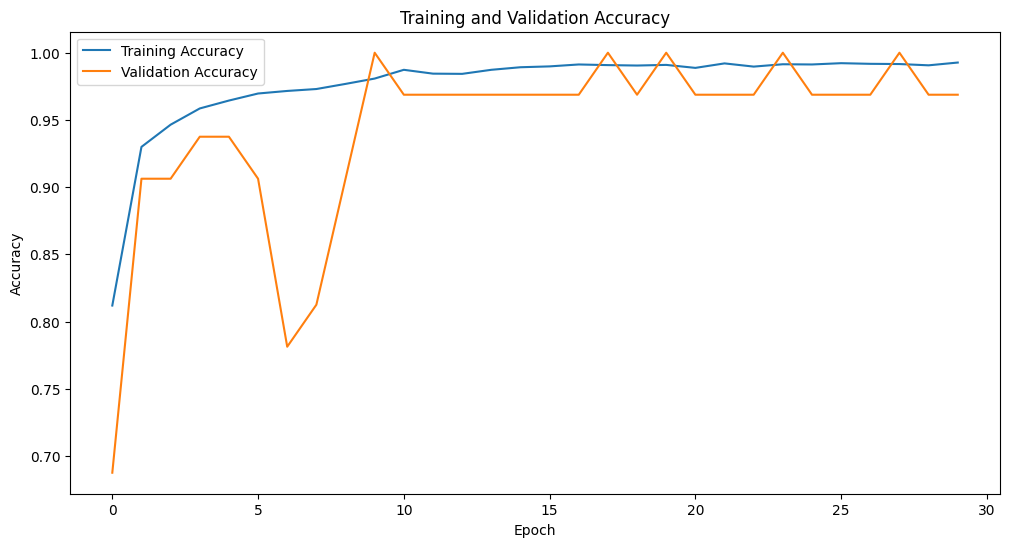

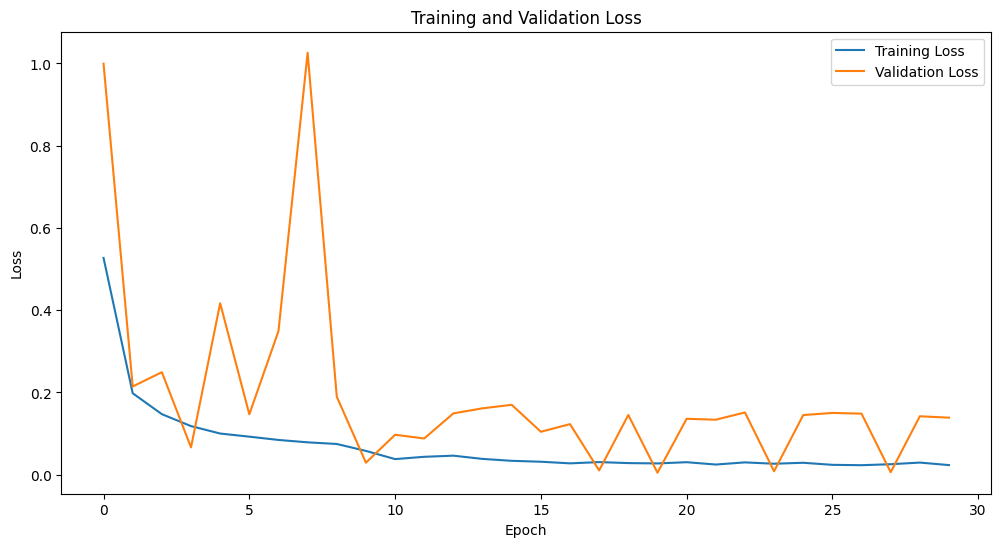

In [27]:
# Plot the training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


25/25 [==============================] - 11s 459ms/step
[[ 15  27  58   6]
 [ 37  69 119   9]
 [ 50 103 213  24]
 [  7   4  28   2]]


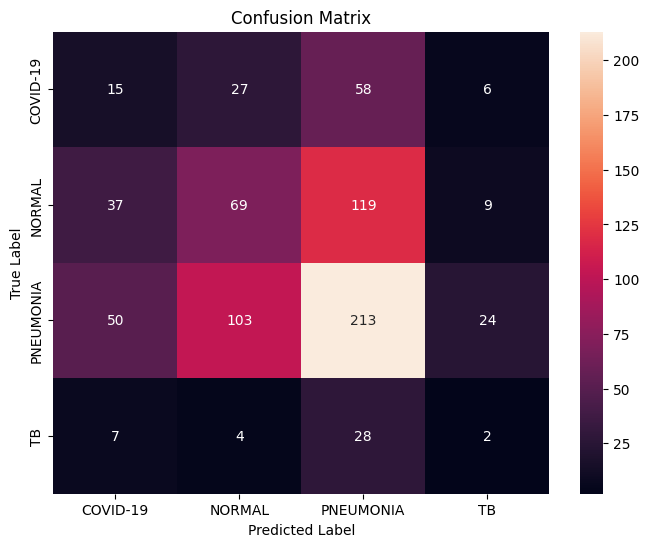

In [29]:
# prompt: confusion matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get the predicted labels for the test data
y_pred = np.argmax(model.predict(test_generator), axis=1)

# Get the true labels for the test data
y_true = test_generator.classes

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Print the confusion matrix
print(cm)

# Visualize the confusion matrix
classes = ['COVID-19', 'NORMAL', 'PNEUMONIA', 'TB']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [30]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
import seaborn as sns

# Generate predictions
test_steps = test_generator.samples // test_generator.batch_size
predictions = model.predict(test_generator, steps=test_steps)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes[:test_steps * test_generator.batch_size]
class_labels = list(test_generator.class_indices.keys())


24/24 [==============================] - 12s 493ms/step


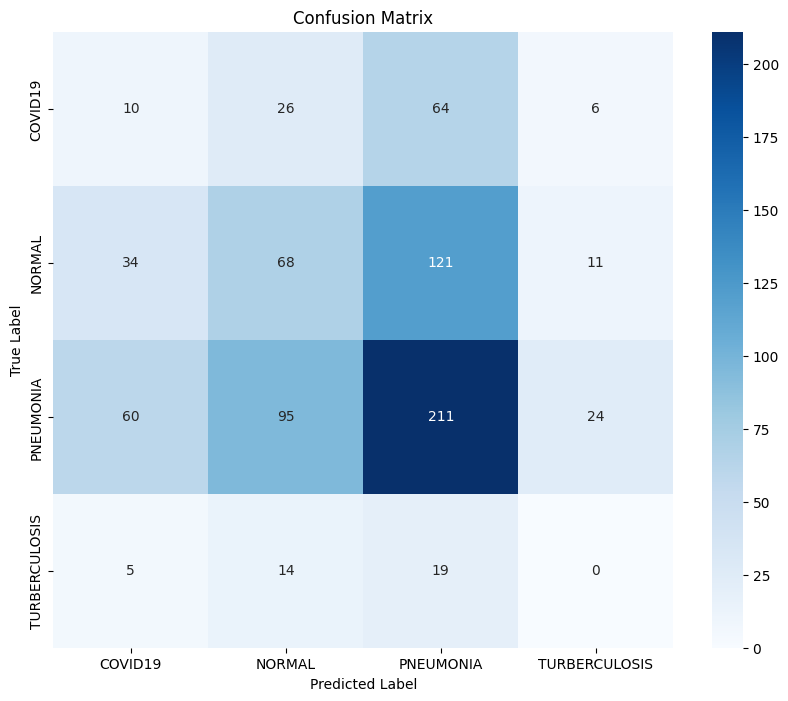

In [31]:

# Plot confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [32]:
# prompt: classification report as table format with precision recall and f1 score and suport values

from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)

# Print classification report as table
print('Classification Report:')
print(report)


Classification Report:
               precision    recall  f1-score   support

      COVID19       0.09      0.09      0.09       106
       NORMAL       0.33      0.29      0.31       234
    PNEUMONIA       0.51      0.54      0.52       390
TURBERCULOSIS       0.00      0.00      0.00        38

     accuracy                           0.38       768
    macro avg       0.23      0.23      0.23       768
 weighted avg       0.37      0.38      0.37       768



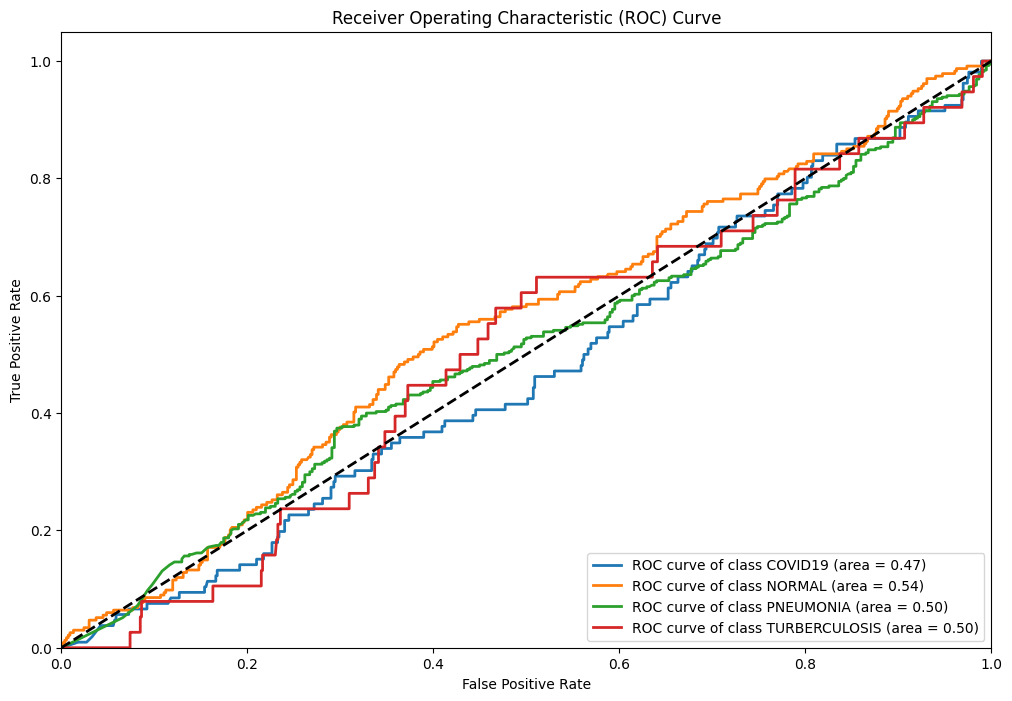

ROC-AUC for class COVID19: 0.47
ROC-AUC for class NORMAL: 0.54
ROC-AUC for class PNEUMONIA: 0.50
ROC-AUC for class TURBERCULOSIS: 0.50


In [33]:
# Compute ROC-AUC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(true_classes, predictions[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC-AUC curve
plt.figure(figsize=(12, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve of class {class_labels[i]} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Print ROC-AUC values
for i in range(num_classes):
    print(f'ROC-AUC for class {class_labels[i]}: {roc_auc[i]:0.2f}')


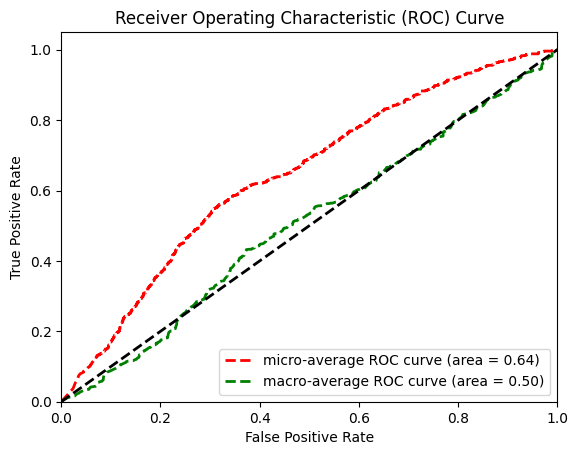

Individual Class ROC-AUC Scores:
ROC-AUC for class COVID19: 0.47
ROC-AUC for class NORMAL: 0.54
ROC-AUC for class PNEUMONIA: 0.50
ROC-AUC for class TURBERCULOSIS: 0.50
Micro-average ROC-AUC: 0.64
Macro-average ROC-AUC: 0.50


In [34]:
from sklearn.preprocessing import label_binarize

# Binarize the true classes
true_classes_bin = label_binarize(true_classes, classes=[0, 1, 2, 3])

# Compute micro-average ROC curve and ROC area
fpr_micro, tpr_micro, _ = roc_curve(true_classes_bin.ravel(), predictions.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Compute macro-average ROC curve and ROC area
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_classes
fpr_macro = all_fpr
tpr_macro = mean_tpr
roc_auc_macro = auc(fpr_macro, tpr_macro)

# Plot micro-average ROC curve
plt.plot(fpr_micro, tpr_micro, linestyle='--', color='red',
         label=f'micro-average ROC curve (area = {roc_auc_micro:0.2f})', lw=2)

# Plot macro-average ROC curve
plt.plot(fpr_macro, tpr_macro, linestyle='--', color='green',
         label=f'macro-average ROC curve (area = {roc_auc_macro:0.2f})', lw=2)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Print ROC-AUC values
print("Individual Class ROC-AUC Scores:")
for i in range(num_classes):
    print(f'ROC-AUC for class {class_labels[i]}: {roc_auc[i]:0.2f}')
print(f'Micro-average ROC-AUC: {roc_auc_micro:0.2f}')
print(f'Macro-average ROC-AUC: {roc_auc_macro:0.2f}')